<a href="https://colab.research.google.com/github/nevil120/Pytorch/blob/main/02_multiclass_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 02. MultiClass Classification

In [ ]:
# Import torch
import torch

# Setup device agnostic code
if torch.cuda.is_available():
  device = 'cuda'
elif torch.backends.mps.is_available():
  device = 'mps'
else:
  device = 'cpu'

print(device)

# Setup random seed
RANDOM_SEED = 42

cuda


## 1. Create a multi-class dataset using the [spirals data creation function from CS231n](https://cs231n.github.io/neural-networks-case-study/) (see below for the code).
  * Split the data into training and test sets (80% train, 20% test) as well as turn it into PyTorch tensors.
  * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
  * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
  * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like) - 1000 epochs should be plenty.
  * Plot the decision boundaries on the spirals dataset from your model predictions, the `plot_decision_boundary()` function should work for this dataset too.

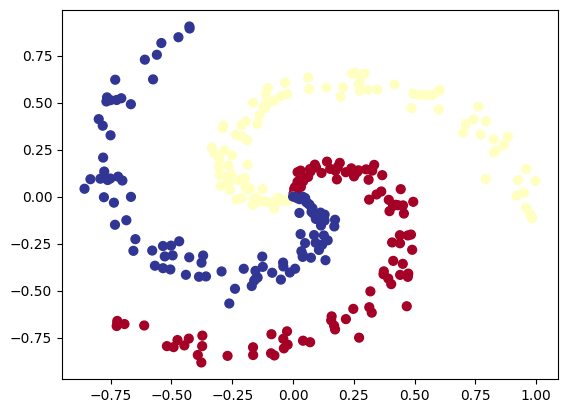

In [ ]:
# Code for creating a spiral dataset from CS231n
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [ ]:
# Turn data into tensors
import torch
X_tensor = torch.from_numpy(X).type(torch.float) # features as float32
y_tensor = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor,
                                                    y_tensor,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED)

In [ ]:
# Let's calculuate the accuracy for when we fit our model
!pip -q install torchmetrics # colab doesn't come with torchmetrics
from torchmetrics import Accuracy

acc_fn = Accuracy(task="multiclass", num_classes=3).to(device)
acc_fn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 962.5/962.5 kB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 52.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 96.8 MB/s eta 0:00:00


MulticlassAccuracy()

In [ ]:
from torch import nn

# Create model by subclassing nn.Module
class SpiralModelV0(nn.Module):
    def __init__(self, in_features, hidden_layer_nodes, out_features):
      super().__init__()
      self.layer_1 = nn.Linear(in_features, hidden_layer_nodes)
      self.layer_2 = nn.Linear(hidden_layer_nodes, hidden_layer_nodes)
      self.layer_3 = nn.Linear(hidden_layer_nodes, out_features)
      self.relu = nn.ReLU()

    def forward(self, x):
        x = self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))
        return x

# Instantiate the model
spiral_model = SpiralModelV0(2, 10, 3).to(device)
spiral_model

SpiralModelV0(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=3, bias=True)
  (relu): ReLU()
)

In [ ]:
# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(spiral_model.parameters(), lr=0.1)

In [ ]:
torch.manual_seed(RANDOM_SEED)

# Setup epochs
epochs = 2000

# Send data to the device
X_train = X_train_tensor.to(device)
X_test = X_test_tensor.to(device)
y_train = y_train_tensor.to(device)
y_test = y_test_tensor.to(device)

# Loop through the data
for epoch in range(epochs):
  ### Training
  spiral_model.train()

  # 1. Forward pass (logits output)
  y_logits = spiral_model(X_train)

  # Turn logits into prediction probabilities
  y_pred_probs = torch.softmax(y_logits, dim=1)

  # Turn prediction probabilities into prediction labels
  y_pred = torch.argmax(y_pred_probs, dim=1)

  # 2. Calculaute the loss
  loss = loss_fn(y_logits, y_train) # loss = compare model raw outputs to desired model outputs

  # Calculate the accuracy
  acc = acc_fn(y_pred, y_train) # the accuracy function needs to compare pred labels (not logits) with actual labels

  # 3. Zero the gradients
  optimizer.zero_grad()

  # 4. Loss backward (perform backpropagation)
  loss.backward()

  # 5. Step the optimizer (gradient descent)
  optimizer.step()

  ### Testing
  spiral_model.eval()
  with torch.inference_mode():
    # 1. Forward pass (to get the logits)
    y_test_logits = spiral_model(X_test)

    # Turn the test logits into prediction labels
    y_test_pred_probs = torch.softmax(y_test_logits, dim=1)

    # 2. Caculate the test loss/acc
    y_test_pred = torch.argmax(y_test_pred_probs, dim=1)

    test_loss = loss_fn(y_test_logits, y_test)
    test_acc = acc_fn(y_test_pred, y_test)

  # Print out what's happening every 100 epochs
  if epoch % 100 == 0:
    print(f"Epoch - {epoch}, train_loss - {loss}, train_acc - {acc}, test_loss - {test_loss}, test_acc - {test_acc}")

Epoch - 0, train_loss - 1.146257996559143, train_acc - 0.32499998807907104, test_loss - 1.106656551361084, test_acc - 0.36666667461395264
Epoch - 100, train_loss - 0.9493642449378967, train_acc - 0.6416666507720947, test_loss - 0.9667419791221619, test_acc - 0.5833333134651184
Epoch - 200, train_loss - 0.7486265897750854, train_acc - 0.550000011920929, test_loss - 0.76712965965271, test_acc - 0.5
Epoch - 300, train_loss - 0.6997977495193481, train_acc - 0.5583333373069763, test_loss - 0.7103703022003174, test_acc - 0.550000011920929
Epoch - 400, train_loss - 0.6675657033920288, train_acc - 0.5708333253860474, test_loss - 0.674538791179657, test_acc - 0.5666666626930237
Epoch - 500, train_loss - 0.6256897449493408, train_acc - 0.6041666865348816, test_loss - 0.6234933137893677, test_acc - 0.6000000238418579
Epoch - 600, train_loss - 0.5659608840942383, train_acc - 0.6499999761581421, test_loss - 0.5500146746635437, test_acc - 0.6499999761581421
Epoch - 700, train_loss - 0.48548185825347

## 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [ ]:
# Plot the model predictions
import numpy as np

def plot_decision_boundary(model, X, y):

    # Put everything to CPU (works better with NumPy + Matplotlib)
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")

    # Source - https://madewithml.com/courses/foundations/neural-networks/
    # (with modifications)
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101),
                         np.linspace(y_min, y_max, 101))

    # Make features
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()

    # Make predictions
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)

    # Test for multi-class or binary and adjust logits to prediction labels
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # mutli-class
    else:
        y_pred = torch.round(torch.sigmoid(y_logits)) # binary

    # Reshape preds and plot
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

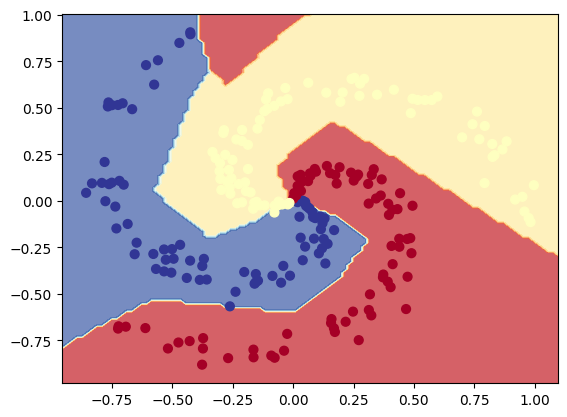

In [ ]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(spiral_model, X_train, y_train)

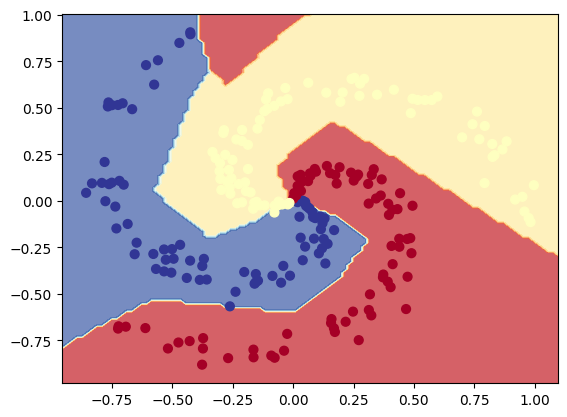

In [ ]:
# Plot decision boundaries for training and test sets
plot_decision_boundary(spiral_model, X_train, y_train)